In [1]:
from IPython.display import Image
import numpy as np
import scipy as sp
import pymc3 as pm
import seaborn as sns
import theano as th
import theano.tensor as tt

import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import reduce
from plotutils import addtxt
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
mpl.style.use(['./scripts/theme_bw.mplstyle', './scripts/presentation.mplstyle'])

Assume a straight-line model, the $k$-th data point is given by

$\begin{align}
y_k &= m x_k + b
\end{align}$

We are given a set of data points $\{Y_k\}$, at positions $\{x_k\}$, but we are not given the errors this time, although we do assume it is gaussian.

$\begin{align}
P(X|D I) &= \int\text{d}\sigma P(X\sigma | DI) \\
&= \int\text{d}\sigma \frac{P(D | X \sigma I) P(X\sigma | I)}{P(D|I)} \\
&\propto \int\text{d}\sigma P(D|X\sigma I)P(X\sigma|I)
\end{align}$

For independent gaussian noise we still have

$\begin{align}
P(D|X\sigma I) &\propto \frac{1}{\sigma^N} \exp{\left[-\frac{1}{2\sigma^2}\sum\left(m x_k +c - Y_k\right)^2\right]} 
\end{align}$

so the likelihood is given as (assuming uniform priors)

$\begin{align}
P(X | D I) &\propto \int\text{d}\sigma \sigma^{-N} \exp\left[-\frac{1}{\sigma^2}\sum\left(m x_k + c - Y_k\right)^2\right] \\
&=\left[\sum \left(m x_k + c - Y_k\right)^2\right]^{-(N-1)/2}
\end{align}$

and the log likelihood becomes

$\begin{align}
L &= \text{constant} - \frac{N-1}{2}\log{\chi^2}\\
\end{align}$

To maximize this likelihood, we should again minimize $\chi^2$, just as in the case when the errors $\sigma_k$ are given.

$\begin{align}
\nabla L &= -\frac{N-1}{2}\frac{1}{\chi^2}\nabla\chi^2\\
&= -\frac{1}{2}\left(\frac{N-1}{\chi^2}\right)\left\{\begin{pmatrix}\alpha^\prime & \gamma^\prime \\\gamma^\prime & \beta^\prime\end{pmatrix}\begin{pmatrix}m \\c\end{pmatrix} -\begin{pmatrix}p^\prime\\q^\prime\end{pmatrix}\right\}
\end{align}$

We recover the same optimum solution ($\nabla L = \nabla\chi^2 \equiv 0$), given by

$\begin{align}
\begin{pmatrix}m_0\\c_0\end{pmatrix} &= \frac{1}{\alpha^\prime \beta^\prime - \gamma^{\prime 2}}\begin{pmatrix}\beta^\prime p^\prime - \gamma^\prime q^\prime \\\alpha^\prime q^\prime - \gamma^\prime p^\prime\end{pmatrix}
\end{align}$

$\begin{align}
\nabla\nabla L &= -\frac{1}{2}\frac{N-1}{\chi^2}\nabla\nabla\chi^2 + \frac{1}{2}\frac{N-1}{\left(\chi^2\right)^{-2}}\nabla\chi^2 \\
\nabla\nabla L(\boldsymbol{X}_0) &= -\frac{1}{2}\frac{N-1}{\chi^2(\boldsymbol{X_0})}\nabla\nabla\chi^2 = -\frac{1}{2}\nabla\nabla\frac{\chi^2}{S^2}
\end{align}$

where we defined $S^2$ as the estimate of $\sigma^2$, equal for all data points, and recovered exactly the same solution as the case when the $\sigma_k$ are specified, i.e.,

$\begin{align}
\alpha &= \alpha^\prime / S^2, \qquad \beta = \beta^\prime/S^2, \qquad \gamma = \gamma^\prime/S^2, \qquad p = p^\prime / S^2, \qquad q = q^\prime / S^2, \qquad w=w_k = 2/S^2, \qquad \sigma_k^2 = S^2 = \frac{1}{N-1}\sum\left(m_0 x_k + c_0 - Y_k\right)^2
\end{align}$

Finally, the covariance matrix is given by

$\begin{align}
\boldsymbol{\sigma}^2 &= -\left(\nabla\nabla L\right)^{-1} = 2 S^2 \left(\nabla\nabla\chi^2\right)^{-1} \\
&= 2\frac{\chi^2(\boldsymbol{X_0})}{N-1}\left(\nabla\nabla\chi^2\right)^{-1}
\end{align}$

In [2]:
size = 200
gold_intercept, gold_slope = 1,2

x = np.linspace(0, 1, size)
# y = m x + b
gold_line = gold_slope * x + gold_intercept
# add noise
y = gold_line + np.random.normal(scale=0.5, size=size)

data = dict(x=x, y=y)

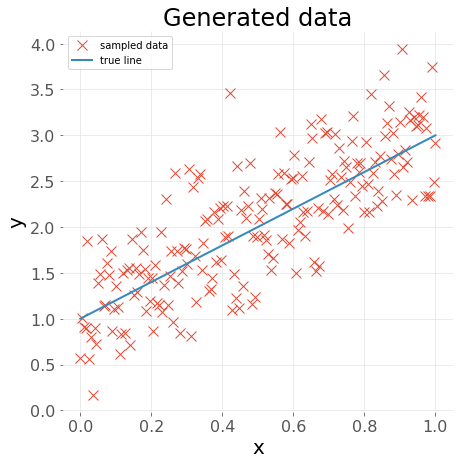

In [3]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data')
ax.plot(x, y, 'x', label='sampled data')
ax.plot(x, gold_line, label='true line', lw=2.)
plt.legend(loc=0);

In [4]:
# Analytical solution
def chi2(p):
    return np.sum((p[0]*x + p[1] - y)**2)
def optimal(xval, yval):
    N = len(xval)
    alpha, beta, gamma = np.sum(xval**2), N, np.sum(xval)
    p, q = np.sum(xval*yval), np.sum(yval)
    idet = 1.0 / (alpha*beta - gamma**2)
    m, c = idet*(beta*p - gamma*q), idet*(alpha*q - gamma*p)
    s2   = np.sum((m*xval + c - yval)**2)/(N-1)
    return np.array([m,c]), 2*s2*idet*np.array([[beta, -gamma], [-gamma, alpha]])
xopt, xcov = optimal(x,y)
print('chi2= {0:.3e}'.format(chi2(xopt)))
print('m_0 = {0:.2f} +/- {1:.2e}'.format(xopt[0], np.sqrt(xcov[0][0])))
print('c_0 = {0:.2f} +/- {1:.2e}'.format(xopt[1], np.sqrt(xcov[1][1])))

chi2= 4.084e+01
m_0 = 2.05 +/- 1.56e-01
c_0 = 1.03 +/- 9.03e-02


In [6]:
opt = sp.optimize.minimize(chi2, [0, 0], method='BFGS', options={'maxiter':1000, 'disp':0})
xcov  = 2*opt['fun']/len(x)*opt['hess_inv']
print('chi2= {0:.3e}'.format(fopt))
print('m_0 = {0:.2f} +/- {1:.2e}'.format(xopt[0], np.sqrt(xcov[0][0])))
print('c_0 = {0:.2f} +/- {1:.2e}'.format(xopt[1], np.sqrt(xcov[1][1])))

chi2= 4.084e+01
m_0 = 2.05 +/- 1.10e-01
c_0 = 1.03 +/- 6.37e-02


In [7]:
# MCMC
with pm.Model() as model:
    #priors for unkown model parameters
    m = pm.Uniform('m', lower=0, upper=10)
    c = pm.Uniform('c', lower=0, upper=10)
    s = pm.Uniform('s', lower=0, upper=10)
    yobs = pm.Normal('yobs', mu=m*x + c, sd=s, observed = y)
    trace = pm.sample(10000, tune = 10000, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [s, c, m]
Sampling 2 chains: 100%|██████████| 40000/40000 [00:23<00:00, 1683.50draws/s]


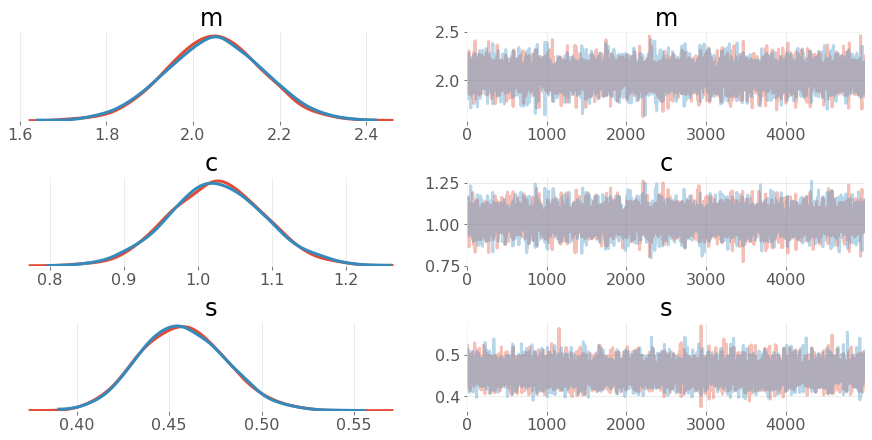

In [8]:
pm.traceplot(trace[5000:]);

<Figure size 504x504 with 0 Axes>

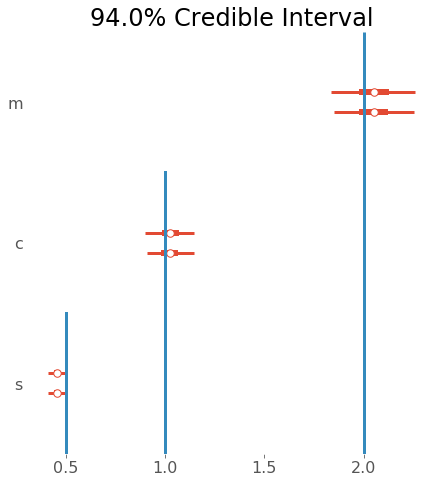

In [10]:
fig = plt.figure(figsize=(7,7))
pm.forestplot(trace);
plt.axvline(0.5, 0, 1/3, c='C1')
plt.axvline(1.0, 0, 2/3, c='C1')
plt.axvline(2.0, 0, 1, c='C1')
plt.show()

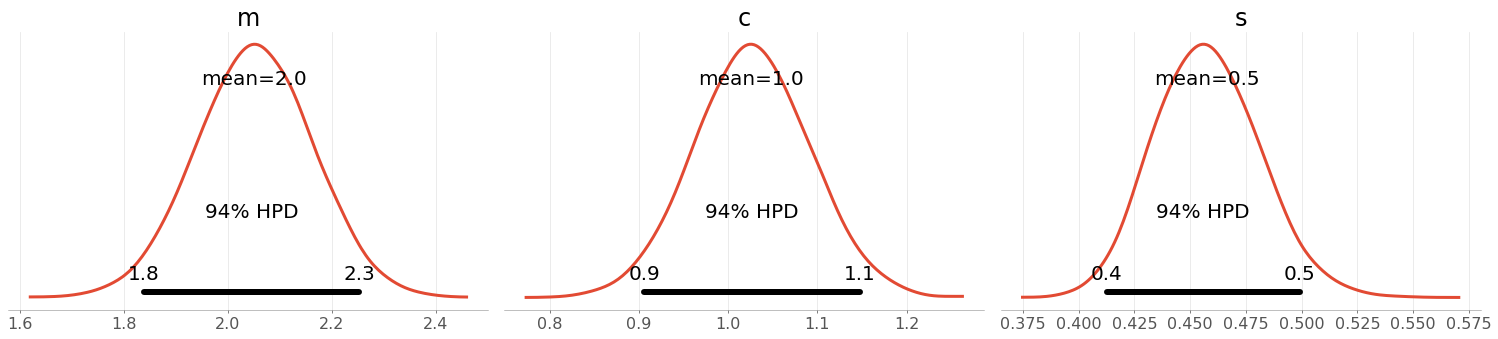

In [11]:
pm.plot_posterior(trace, kde_plot=True);

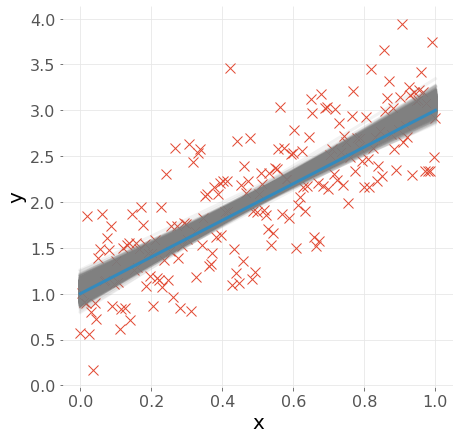

In [12]:
plt.figure(figsize=(7,7))
plt.plot(x, y,'x', label='data')
niter = len(trace['m'])
for _m,_c in zip(trace['m'][niter//2::5], trace['c'][niter//2::5]):
    plt.plot(x, _m*x + _c, c='gray', alpha=0.1)
plt.plot(x, gold_line, label='true regression line', lw=3)
plt.xlabel('x')
plt.ylabel('y');